In [1]:
import pandas as  pd
import numpy as np

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("../data/Placement_Data_Full_Class.csv")
df.head(10)

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.00,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.50,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.00,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.00,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.80,Mkt&Fin,55.50,Placed,425000.0
5,6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.00,Mkt&Fin,51.58,Not Placed,NaN
6,7,F,46.00,Others,49.20,Others,Commerce,79.00,Comm&Mgmt,No,74.28,Mkt&Fin,53.29,Not Placed,NaN
7,8,M,82.00,Central,64.00,Central,Science,66.00,Sci&Tech,Yes,67.00,Mkt&Fin,62.14,Placed,252000.0
8,9,M,73.00,Central,79.00,Central,Commerce,72.00,Comm&Mgmt,No,91.34,Mkt&Fin,61.29,Placed,231000.0
9,10,M,58.00,Central,70.00,Central,Commerce,61.00,Comm&Mgmt,No,54.00,Mkt&Fin,52.21,Not Placed,NaN


In [3]:
df.describe()

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,108.000000,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,62.209324,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,1.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,54.500000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,108.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,161.500000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,215.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [4]:
# для нашей задачи нам не нужны колонки с зарплатой и нумерацией -- сразу удаляем их
df.drop(['sl_no','salary'], axis=1, inplace=True)
df.head(3)

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed


In [5]:
df['status'].value_counts()

Placed        148
Not Placed     67
Name: status, dtype: int64

In [6]:
df.isna().sum()

gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
workex            0
etest_p           0
specialisation    0
mba_p             0
status            0
dtype: int64

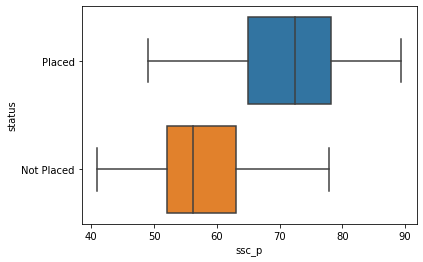

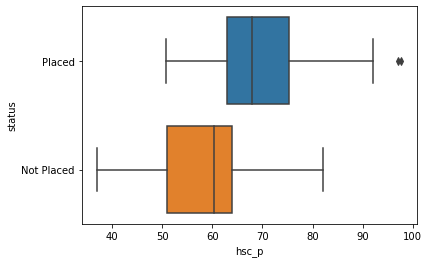

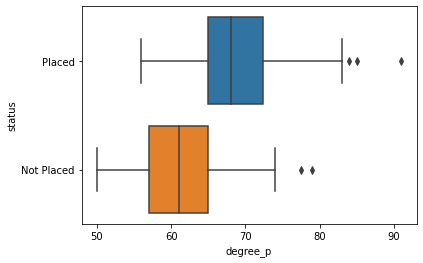

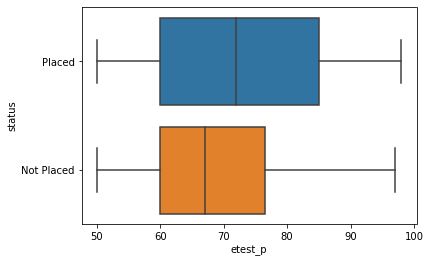

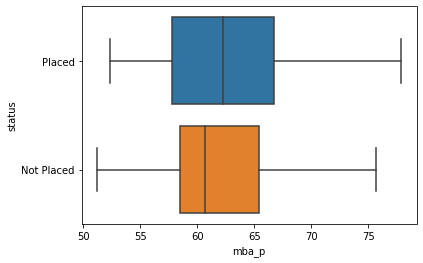

In [7]:
# визуализируем параметры
for i in df.select_dtypes(exclude='object').columns:
    sns.boxplot(x=df[i],y = df['status'])
    plt.show()

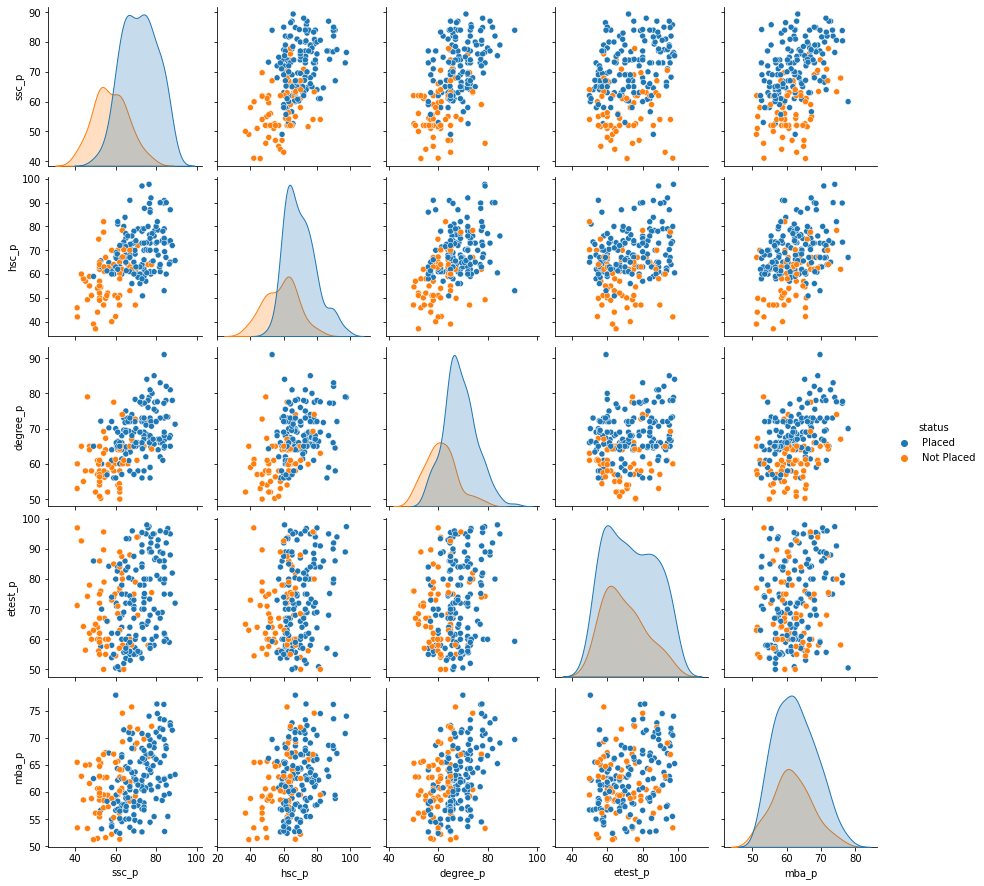

In [8]:
sns.pairplot(data=df,hue="status")

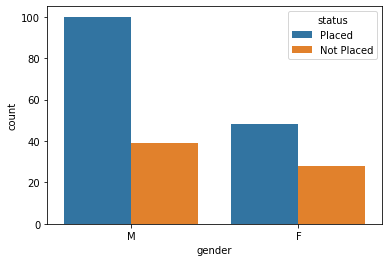

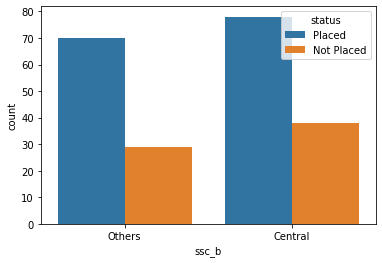

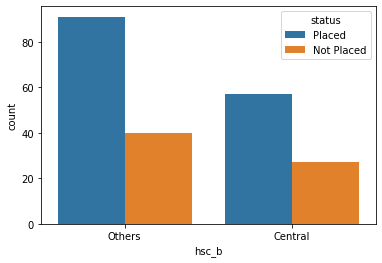

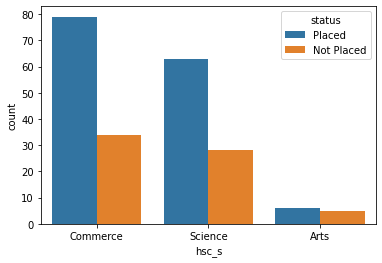

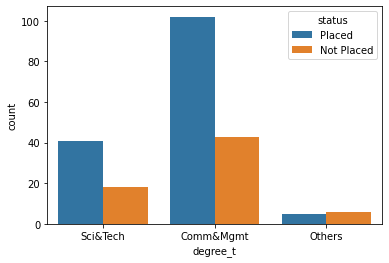

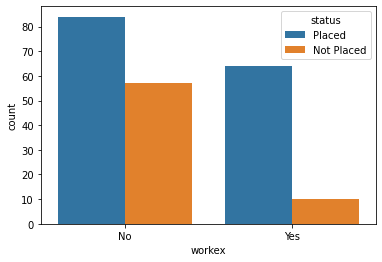

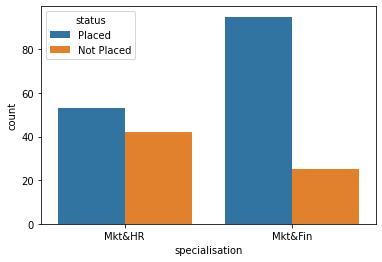

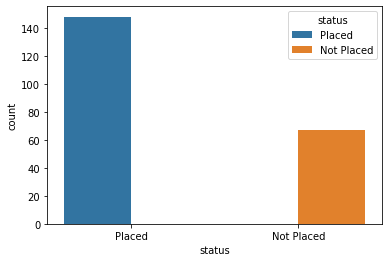

In [9]:
for col in df.select_dtypes(include='object'):
    sns.countplot(x=col, hue  ='status', data=df)
    plt.show()

In [10]:
df.corr()

,ssc_p,hsc_p,degree_p,etest_p,mba_p
ssc_p,1.000000,0.511472,0.538404,0.261993,0.388478
hsc_p,0.511472,1.000000,0.434206,0.245113,0.354823
degree_p,0.538404,0.434206,1.000000,0.224470,0.402364
etest_p,0.261993,0.245113,0.224470,1.000000,0.218055
mba_p,0.388478,0.354823,0.402364,0.218055,1.000000


Возьмем наиболее влияющие признаки: ssc_p, hsc_p, degree_p

In [11]:
df['ssc_p'].describe()

count    215.000000
mean      67.303395
std       10.827205
min       40.890000
25%       60.600000
50%       67.000000
75%       75.700000
max       89.400000
Name: ssc_p, dtype: float64

In [12]:
df['hsc_p'].describe()

count    215.000000
mean      66.333163
std       10.897509
min       37.000000
25%       60.900000
50%       65.000000
75%       73.000000
max       97.700000
Name: hsc_p, dtype: float64

In [13]:
df['degree_p'].describe()

count    215.000000
mean      66.370186
std        7.358743
min       50.000000
25%       61.000000
50%       66.000000
75%       72.000000
max       91.000000
Name: degree_p, dtype: float64

In [14]:
# заменим значения поля status на 0 и 1
df['status'].replace(('Placed', 'Not Placed'), (1, 0), inplace=True)
df.head(5)

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,1
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,1
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,1
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,0
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,1


### Строим модель и пайплайн

In [15]:
features = ['ssc_p', 'hsc_p', 'degree_p']
target = ['status']

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.33, random_state=10)
#save test
X_test.to_csv("../data/X_test.csv", index=None)
y_test.to_csv("../data/y_test.csv", index=None)
#save train
X_train.to_csv("../data/X_train.csv", index=None)
y_train.to_csv("../data/y_train.csv", index=None)

In [16]:
#соберем наш простой pipeline
 
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
  
continuous_columns = features
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])


In [17]:
model = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

In [18]:
predictions =  model.predict(X_test)
print(roc_auc_score(y_test,predictions))
print(r2_score(y_pred=predictions, y_true=y_test))
print(mean_absolute_error(y_pred=predictions, y_true=y_test))
predictions

0.8417391304347825
0.3452947424356172
0.22181185039701465


array([ 1.04067624e+00,  1.97151676e-02,  9.15108800e-01,  6.04328752e-01,
        9.77801025e-01,  2.64431862e-03,  9.76348698e-01,  1.05229902e+00,
        1.83534399e-01,  1.10818779e+00,  9.10694838e-01,  1.14829195e+00,
        1.00664163e+00,  1.03702867e+00,  2.78333634e-01,  1.97774053e-01,
        1.73758790e-01,  9.99435842e-01,  1.08641291e+00,  9.70569015e-01,
        9.99714911e-01,  9.66912925e-01,  4.41121817e-01, -5.60082775e-03,
        1.19505346e-01,  8.77159178e-01,  9.67252970e-01,  2.65105546e-01,
        9.99766529e-01,  3.35446805e-01,  1.03187299e+00,  7.32041372e-04,
        6.28932536e-01, -1.41168823e-02, -7.40136728e-02,  9.25009072e-01,
        7.14066327e-01, -1.70021039e-02,  9.56968606e-01,  9.93796110e-01,
        6.99279681e-02,  9.99667823e-01,  8.41264367e-01,  9.99814749e-01,
        9.22246873e-01,  1.01373696e+00, -1.81965306e-01,  1.00011003e+00,
        7.61774242e-01,  1.00008070e+00,  8.90994072e-01,  8.12927127e-01,
        9.99169052e-01,  

In [19]:
# попробуем линейную регрессию
model = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

#обучим наш пайплайн
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

In [20]:
predictions =  model.predict(X_test)
print(roc_auc_score(y_test,predictions))
print(r2_score(y_pred=predictions, y_true=y_test))
print(mean_absolute_error(y_pred=predictions, y_true=y_test))
predictions

0.9008695652173913
0.4273160365841553
0.30305649962682124


array([[ 1.15566298],
       [ 0.17976236],
       [ 0.84130485],
       [ 0.71314668],
       [ 0.80009476],
       [ 0.27149813],
       [ 0.64841082],
       [ 0.9126364 ],
       [ 0.42742889],
       [ 0.53477609],
       [ 1.05865914],
       [ 0.5847821 ],
       [ 1.01852098],
       [ 0.795689  ],
       [ 0.55591562],
       [ 0.46790232],
       [ 0.86034854],
       [ 0.86031626],
       [ 0.56123031],
       [ 0.30283834],
       [ 1.10774525],
       [ 1.11289045],
       [ 0.42303659],
       [-0.02943395],
       [ 0.2878009 ],
       [ 0.61250714],
       [ 0.629087  ],
       [ 0.62049993],
       [ 1.30526502],
       [ 0.6178084 ],
       [ 0.87150506],
       [ 0.28438971],
       [ 0.13016338],
       [-0.06069662],
       [ 0.3407157 ],
       [ 0.60441574],
       [ 0.64288019],
       [ 0.3709749 ],
       [ 0.80108308],
       [ 0.57607792],
       [ 0.97577211],
       [ 1.13753736],
       [ 0.65049744],
       [ 0.73927157],
       [ 0.45009745],
       [ 0